In [0]:
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
clear_output()

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
imdb_df = pd.read_csv("/content/drive/My Drive/SentimentAnalysisClassifier/Dataset/IMDB Dataset.csv")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [125]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [126]:
#Check for nans
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [127]:
#Encodes sentiment of the reviews
imdb_df["target"] = imdb_df.sentiment.astype("category").cat.codes
imdb_df.head()


,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


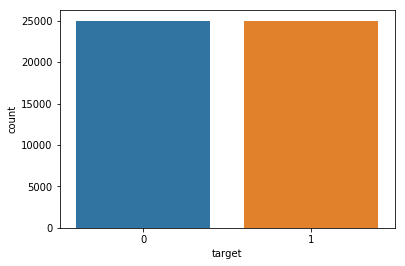

In [128]:
#Checks Dataset balance
sns.countplot(imdb_df["target"])
plt.show()

In [129]:
#Removes "<br />" from the text corpus, that have a high presence in the text corpus
imdb_df["review"] = imdb_df["review"].str.replace("<br />", "")
imdb_df.head()

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [130]:
#Tokenize the string into sequences of int, one unique int for every word found in the text corpus
tokenizer = tf.keras.preprocessing.text.Tokenizer(10000)
tokenizer.fit_on_texts(imdb_df["review"])
imdb_df.insert(1, "tokens", tokenizer.texts_to_sequences(imdb_df["review"]))
imdb_df.head()

,review,tokens,sentiment,target
0,One of the other reviewers has mentioned that ...,"[26, 4, 1, 78, 2099, 44, 1071, 11, 99, 146, 38...",positive,1
1,A wonderful little production. The filming tec...,"[3, 392, 119, 351, 1, 1384, 2976, 6, 51, 51, 1...",positive,1
2,I thought this was a wonderful way to spend ti...,"[9, 189, 10, 12, 3, 392, 94, 5, 1153, 54, 19, ...",positive,1
3,Basically there's a family where a little boy ...,"[689, 221, 3, 235, 116, 3, 119, 419, 3651, 125...",negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[111, 7, 1, 54, 4, 290, 6, 3, 2139, 1429, 18, ...",positive,1


med: 164.0
95.0%: 548.0


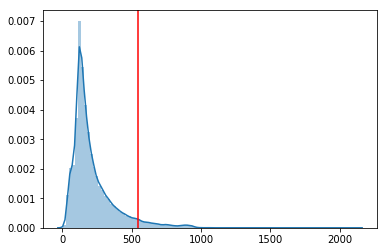

In [131]:
#Search for viable max lenght for seqeuences, avoiding space wasting by large number of zeros in every sequence
tokens_lenght = [len(seq) for seq in imdb_df["tokens"].values]
print("med: " + str(np.median(tokens_lenght)))

data_covered = 0.95
quantile = np.quantile(tokens_lenght, data_covered)
print(str(data_covered * 100) + "%: " + str(quantile))

sns.distplot(tokens_lenght, 100)
plt.axvline(quantile, color="red")
plt.show()

In [132]:
#Truncates only 5% of the data, and pad 95%
max_len = int(quantile)
imdb_df["tokens"] = tf.keras.preprocessing.sequence.pad_sequences(imdb_df["tokens"], max_len, padding="post", truncating="post").tolist()
imdb_df.head()

,review,tokens,sentiment,target
0,One of the other reviewers has mentioned that ...,"[26, 4, 1, 78, 2099, 44, 1071, 11, 99, 146, 38...",positive,1
1,A wonderful little production. The filming tec...,"[3, 392, 119, 351, 1, 1384, 2976, 6, 51, 51, 1...",positive,1
2,I thought this was a wonderful way to spend ti...,"[9, 189, 10, 12, 3, 392, 94, 5, 1153, 54, 19, ...",positive,1
3,Basically there's a family where a little boy ...,"[689, 221, 3, 235, 116, 3, 119, 419, 3651, 125...",negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[111, 7, 1, 54, 4, 290, 6, 3, 2139, 1429, 18, ...",positive,1


(548,)